In [2]:
import os
import scipy.io
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input, Embedding, multiply
from keras.optimizers import RMSprop
import keras.backend as K
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
# --------------------
# 1. Data Loading & Preprocessing
# --------------------

# Function to load and preprocess EEG data from .mat files
def load_eeg_data(class_0_path, class_1_path):
    eeg_data_list = []
    labels_list = []

    # Helper function to extract EEG data from a .mat file
    def extract_eeg_data(file_path):
        mat_data = scipy.io.loadmat(file_path)
        
        # Find the correct key for EEG data (excluding metadata keys)
        data_keys = [key for key in mat_data.keys() if not key.startswith('__')]
        if len(data_keys) == 0:
            raise ValueError(f"No valid EEG data found in {file_path}")

        # Assuming the first valid key contains the EEG data
        eeg_data = mat_data[data_keys[0]]
        
        # Check if it's a numeric matrix
        if not isinstance(eeg_data, np.ndarray):
            raise ValueError(f"Unexpected data type in {file_path}: {type(eeg_data)}")
        
        # Normalize the data between -1 and 1
        eeg_data = eeg_data.astype('float32')
        eeg_data = (eeg_data - np.min(eeg_data)) / (np.max(eeg_data) - np.min(eeg_data)) * 2 - 1
        return eeg_data

    # Load class 0 data (files starting with '0_')
    for file_name in os.listdir(class_0_path):
        if file_name.endswith('.mat') and file_name.startswith('0_'):
            file_path = os.path.join(class_0_path, file_name)
            eeg_data = extract_eeg_data(file_path)
            eeg_data_list.append(eeg_data)
            labels_list.extend([0] * eeg_data.shape[0])  # Append 0 label for each signal in the file

    # Load class 1 data (files starting with '1_')
    for file_name in os.listdir(class_1_path):
        if file_name.endswith('.mat') and file_name.startswith('1_'):
            file_path = os.path.join(class_1_path, file_name)
            eeg_data = extract_eeg_data(file_path)
            eeg_data_list.append(eeg_data)
            labels_list.extend([1] * eeg_data.shape[0])  # Append 1 label for each signal in the file

    # Stack all EEG data and labels into NumPy arrays
    eeg_data = np.vstack(eeg_data_list)
    labels = np.array(labels_list)
    return eeg_data, labels

# Define the paths to the folder with .mat files for each class
folder_0 = r'C:\Users\offic\OneDrive\Masaüstü\datasets\ALS\0'
folder_1 = r'C:\Users\offic\OneDrive\Masaüstü\datasets\ALS\1'

# Load EEG data and labels
eeg_data, labels = load_eeg_data(folder_0, folder_1)
eeg_signal_length = 32  # Each signal is of length 32

print(f"Loaded {eeg_data.shape[0]} samples with signal length {eeg_signal_length}")
print(f"Labels shape: {labels.shape}")


Loaded 7281920 samples with signal length 32
Labels shape: (7281920,)


In [3]:
# --------------------
# 2. WGAN Architecture
# --------------------

# WGAN loss function
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Generator model
def build_generator(latent_dim, eeg_signal_length, num_classes):
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    
    noise = Input(shape=(latent_dim,))
    model_input = multiply([noise, label_embedding])
    
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(eeg_signal_length, activation='tanh'))  # Output is an EEG signal
    model.add(Reshape((eeg_signal_length,)))
    
    generator = Model([noise, label], model(model_input))
    return generator

# Critic (Discriminator) model
def build_critic(eeg_signal_length, num_classes):
    signal = Input(shape=(eeg_signal_length,))
    label = Input(shape=(1,), dtype='int32')
    
    label_embedding = Flatten()(Embedding(num_classes, eeg_signal_length)(label))
    model_input = multiply([signal, label_embedding])
    
    model = Sequential()
    model.add(Dense(1024, input_dim=eeg_signal_length))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1))  # Output is a score
    
    critic = Model([signal, label], model(model_input))
    return critic

# Compile models
latent_dim = 100  # Latent space dimension
num_classes = 2  # Two classes: 0 (True) and 1 (False)
generator = build_generator(latent_dim, eeg_signal_length, num_classes)
critic = build_critic(eeg_signal_length, num_classes)

# WGAN optimizer
optimizer = RMSprop(lr=0.00005)

critic.compile(loss=wasserstein_loss, optimizer=optimizer)
generator.compile(loss=wasserstein_loss, optimizer=optimizer)


2/2 [==============================] - 0s 3ms/step
Epoch 0/300 | D Loss: 0.0000 | G Loss: 0.0006
2/2 [==============================] - 0s 3ms/step
Epoch 100/300 | D Loss: -0.0088 | G Loss: -0.5422
2/2 [==============================] - 0s 2ms/step
Epoch 200/300 | D Loss: -0.1067 | G Loss: -0.9867
2/2 [==============================] - 0s 3ms/step


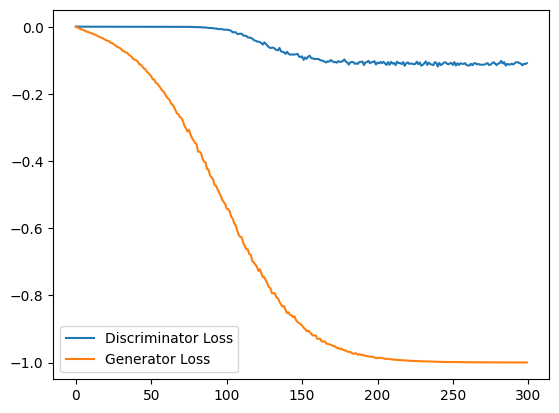

In [4]:
# --------------------
# 3. Training the WGAN
# --------------------

# Hyperparameters
epochs = 300
batch_size = 64
n_critic = 5  # Number of critic updates per generator update
clip_value = 0.01  # Clipping parameter for WGAN

# Create random noise for generator training
def generate_latent_points(latent_dim, n_samples):
    return np.random.randn(n_samples, latent_dim)

# Train WGAN
def train_wgan(generator, critic, eeg_data, labels, epochs, batch_size, latent_dim, n_critic, clip_value):
    d_losses, g_losses = [], []

    real = -np.ones((batch_size, 1))
    fake = np.ones((batch_size, 1))

    for epoch in range(epochs):
        for _ in range(n_critic):
            idx = np.random.randint(0, eeg_data.shape[0], batch_size)
            real_eeg = eeg_data[idx]
            real_labels = labels[idx]

            noise = generate_latent_points(latent_dim, batch_size)
            generated_eeg = generator.predict([noise, real_labels])

            d_loss_real = critic.train_on_batch([real_eeg, real_labels], real)
            d_loss_fake = critic.train_on_batch([generated_eeg, real_labels], fake)

            for layer in critic.layers:
                weights = layer.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                layer.set_weights(weights)

        noise = generate_latent_points(latent_dim, batch_size)
        g_loss = generator.train_on_batch([noise, real_labels], real)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")
    
    return d_losses, g_losses

# Start training
d_losses, g_losses = train_wgan(generator, critic, eeg_data, labels, epochs, batch_size, latent_dim, n_critic, clip_value)

# Plot the loss curves
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.legend()
plt.show()

In [5]:
# Save the generator and critic models
generator.save('wgan_generator.keras')
critic.save('wgan_critic.keras')

print("Models have been saved.")

Models have been saved.


In [ ]:
from keras.models import load_model
import os
import numpy as np
import keras.backend as K
from scipy.io import savemat  # Import savemat to save files in .mat format

# WGAN loss function
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Load the trained generator model
generator = load_model('wgan_generator.keras', custom_objects={'wasserstein_loss': wasserstein_loss})

# Function to generate a batch of new signals with the label "0" only
def generate_new_signals(generator, latent_dim, num_samples, label):
    # Generate random noise
    noise = np.random.randn(num_samples, latent_dim)
    # Create an array of labels with "0"
    labels = np.zeros(num_samples, dtype=int)
    
    # Generate signals using the generator model
    generated_signals = generator.predict([noise, labels])
    
    return generated_signals

# Parameters for signal generation
num_samples = 2560  # Number of samples per file
latent_dim = 100    # Dimensionality of the latent space
num_classes = 2     # Number of classes (generator was trained with 2)

# Output directory for generated files
output_dir = "generated_files"
os.makedirs(output_dir, exist_ok=True)

# Generate and save 10,000 files
num_files = 10000
for i in range(num_files):
    # Generate signals with label "0" only
    generated_signals = generate_new_signals(generator, latent_dim, num_samples, label=0)
    
    # Ensure the shape is (2560, 32)
    if generated_signals.shape[1] != 32:
        raise ValueError("Generated signals do not have the expected shape (2560, 32). Check the generator architecture.")
    
    # Save the generated signals to a .mat file
    output_path = os.path.join(output_dir, f"generated_signals_{i + 1}.mat")
    savemat(output_path, {'generated_signals': generated_signals})
    
    if (i + 1) % 100 == 0:  # Print progress every 100 files
        print(f"Saved {i + 1}/{num_files} files.")

print("All files have been generated and saved successfully.")


80/80 [==============================] - 0s 2ms/step
Saved 100/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 200/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 300/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 400/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 500/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 600/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 700/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 800/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 900/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 1000/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 1100/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 1200/10000 files.
80/80 [==============================] - 0s 2ms/step
Saved 1300/10000 files.
80/80 [=